In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors

%matplotlib inline

In [2]:
def load_cosmicflows_data(cosmicflow_name):
    dtype=[('PGC' ,'i8'),('dist' ,'f8'),('Nd','i8'),('RAJ','S8'),('DECJ','S8'),('Ks', 'f8'),('VCMB','f8'),('VMOD','f8')]
    snap_data = np.loadtxt(cosmicflow_name, dtype=dtype)    
    return snap_data

In [3]:
!head ../data/obs/cosmicflows.dat

#"Cosmicflows-3 Distances" "Cosmicflows-3 Distances" "Cosmicflows-3 Distances" "Cosmicflows-3 Distances" "Cosmicflows-3 Distances" "Cosmicflows-3 Distances" "Cosmicflows-3 Distances"
#pgc Dist Nd RAJ DeJ Ks Vcmb Vmod
#%7s %6.2f %1d %8s %9s %5.2f %5d %5d
#--- Mpc  hms damas mag km/s km/s
#"The Catalogue of Principal Galaxies (PGC) Number" "Luminosity distance (weighted average if more than one source)" "Number of distance sources" "Right Ascension (J2000)" "Declination (J2000)" "2MASS Ks magnitude, extinction corrected from Huchra et al. 2012 or else Lavaux-Hudson 2011" "Velocity in CMB standard of rest (Fixsen et al. 1996)" "Velocity in CMB standard of rest adjusted in accordance with a cosmological model with Omega_matter=0.27 and Omega_Lambda=0.73"
4 50.58 1 000003.5 +230515 0.00 4109 4154
27 150.66 1 000023.5 -065610 0.00 10959 11275
40 116.95 1 000035.6 -014547 0.00 6919 7045
51 240.99 1 000035.8 -403432 0.00 14771 15342
55 73.79 1 000037.4 +333603 0.00 4454 4507


In [4]:
data = load_cosmicflows_data("../data/obs/cosmicflows.dat")

In [5]:
n_points = len(data)
ra_data = np.array(np.zeros(n_points), dtype=[('RA', 'f8')])
dec_data = np.array(np.zeros(n_points), dtype=[('DEC', 'f8')])

for i in range(n_points):
    raj = data['RAJ'][i].decode()
    decj = data['DECJ'][i].decode()
    rah = float(raj[0:2])#hours
    ram = float(raj[2:4])#minutes
    ras = float(raj[4:])#seconds
    if(len(decj)==7):
        decd = float(decj[0:3])#degrees
        decam = float(decj[3:5])#arcminutes
        decas = float(decj[5:7])#arcseconds
    elif(len(decj)==6):
        decd = float(decj[0:2])#degrees
        decam = float(decj[2:4])#arcminutes
        decas = float(decj[4:6])#arcseconds
    if(decj[0]=='-'):
        sign = -1.0
    else:
        sign = +1.0
    ra_data['RA'][i] = (rah + ram/60.0 + ras/3600.0) * (360.0/24.0)
    dec_data['DEC'][i] = decd + sign*decam/60.0 + sign*decas/3600.0
    
    if(dec_data['DEC'][i]>90.0):
        print(i, decj, len(decj), data['DECJ'][i], dec_data['DEC'][i])

2755


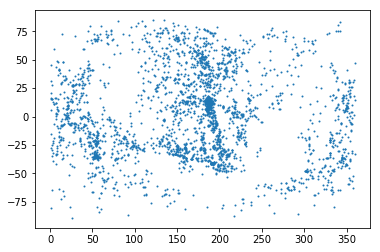

In [6]:
max_distance = 45.0
plt.scatter(ra_data['RA'][data['dist']<max_distance],dec_data['DEC'][data['dist']<max_distance], s =1.0)
print(len(ra_data['RA'][data['dist']<max_distance]))

In [7]:
cartesian_data = np.ones((n_points,3))
theta = np.deg2rad(dec_data['DEC'] - 90.0)
phi = np.deg2rad(ra_data['RA'])
cartesian_data[:,0] = data['dist'] * np.sin(theta) * np.cos(phi)
cartesian_data[:,1] = data['dist'] * np.sin(theta) * np.sin(phi)
cartesian_data[:,2] = data['dist'] * np.cos(theta)
cartesian_data = cartesian_data[data['dist']<max_distance,:]
vradial_data = data['VCMB'][data['dist']<max_distance]
dradial_data = data['dist'][data['dist']<max_distance]

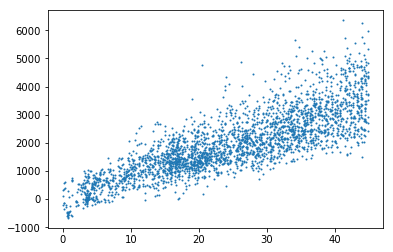

In [8]:
plt.scatter(dradial_data, vradial_data, s=1.0)

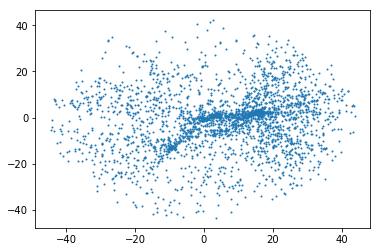

In [9]:
plt.scatter(cartesian_data[:,0], cartesian_data[:,1], s=1.0)

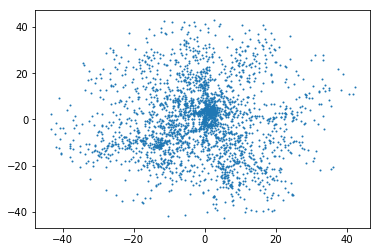

In [10]:
plt.scatter(cartesian_data[:,1], cartesian_data[:,2], s=1.0)

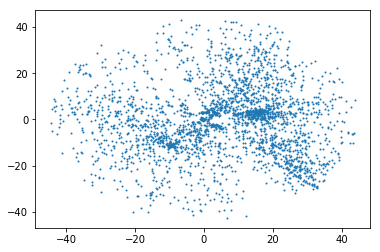

In [11]:
plt.scatter(cartesian_data[:,0], cartesian_data[:,2], s=1.0)

In [12]:
nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(cartesian_data)
dist, ind = nbrs.kneighbors(cartesian_data)
print(dist.shape)
neighbor_index = ind[:,1]
neighbor_list = ind[:,2:]
print(np.shape(neighbor_list))

#define pairs
n_pairs = 0
halo_A_id = np.empty((0), dtype=int)
halo_B_id = np.empty((0), dtype=int)
n = len(cartesian_data)
print(n)
for i in range(n):
    j = neighbor_index[i] % n # nearest neighbor of i
    l = neighbor_index[neighbor_index[i]]% n # nearest neighbor of j
    other_j = neighbor_list[i,:] % n # all neightbors of i.
    other_l = neighbor_list[neighbor_index[i],:] % n # all neightbors of i-th's neighbors
    if(i==l):# reciprocity principle
        if((not (j in halo_A_id)) & (not (i in halo_B_id))): # don't add pairs that are already in the list
            dist_limit = 2.5
            massive_close_to_i = any((dist[i,2:]<dist_limit))
            massive_close_to_j = any((dist[j,2:]<dist_limit))
            if((not massive_close_to_i) & (not massive_close_to_j)): 
                n_pairs = n_pairs + 1
                halo_A_id = np.append(halo_A_id, int(i))
                halo_B_id = np.append(halo_B_id, int(j))
print(n_pairs)

(2755, 20)
(2755, 18)
2755
294


In [13]:
pair_3d = np.sqrt((cartesian_data[halo_B_id, 0] - cartesian_data[halo_A_id,0])**2
                 +(cartesian_data[halo_B_id, 1] - cartesian_data[halo_A_id,1])**2
                 +(cartesian_data[halo_B_id, 2] - cartesian_data[halo_A_id,2])**2)
pair_d = (cartesian_data[halo_B_id, 2] - cartesian_data[halo_A_id,2])
hubble = 78.0
pair_v = (vradial_data[halo_B_id] - dradial_data[halo_B_id]*hubble) - (vradial_data[halo_A_id] -dradial_data[halo_A_id]*hubble)

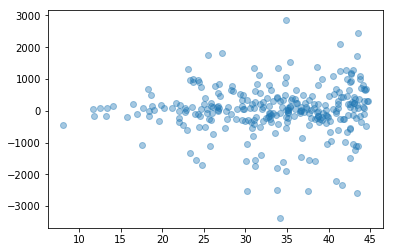

In [25]:
plt.scatter(0.5*(dradial_data[halo_B_id]+dradial_data[halo_A_id]), pair_v, alpha=0.4)

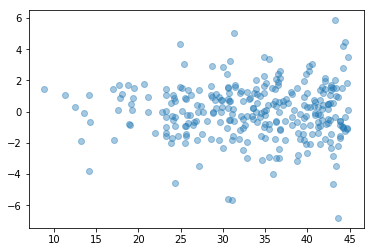

In [23]:
plt.scatter(dradial_data[halo_B_id], pair_d, alpha=0.4)

(0, 900)

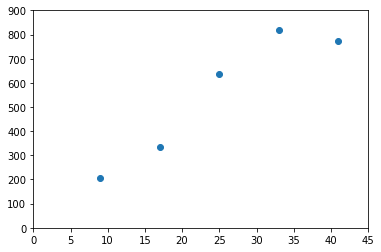

In [109]:
d_bins = np.arange(5,50,8)
d_center = 0.5*(d_bins[0:-1] + d_bins[1:])
n_bins = len(d_center)
n_inside = np.zeros(n_bins)
sigma_d = np.zeros(n_bins)
sigma_0 = np.zeros(n_bins)
sigma_v = np.zeros(n_bins)
for i in range(n_bins):
    mid = 0.5*(dradial_data[halo_B_id]+dradial_data[halo_A_id])
    ii = (mid>d_bins[i]) & (mid<d_bins[i+1])
    if(np.count_nonzero(ii)):
        n_in = np.count_nonzero(ii) 
        sigma_d[i] = pair_d[ii].std()
        sigma_v[i] = pair_v[ii].std()
        sigma_0[i] = np.sqrt(sigma_v[i]**2 - (d_center[i]*78*0.10)**2)
        n_inside[i] = np.count_nonzero(ii)
#plt.plot(d_center, sigma_d)
plt.scatter((d_center), sigma_0)
plt.xlim([0,45])
plt.ylim([0,900])

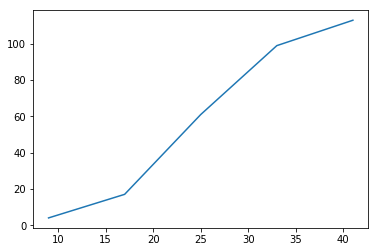

In [110]:
plt.plot(d_center, n_inside)

/Users/forero/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


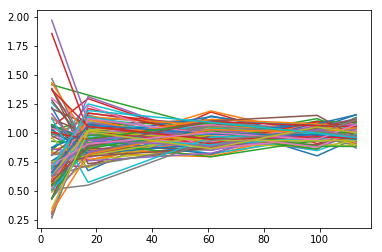

In [127]:
for j in range(100):
    stddev = np.ones(len(n_inside))
    for i in range(len(n_inside)):
        x = np.random.normal(size=n_inside[i])
        stddev[i] = x.std()
    plt.plot(n_inside, stddev)

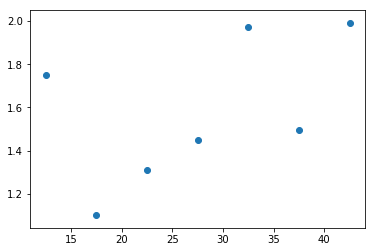

In [65]:
plt.scatter(d_center, sigma_d)

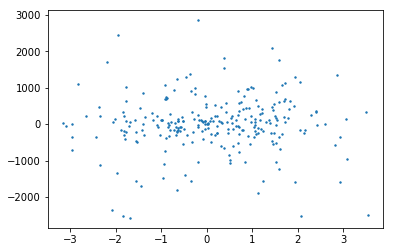

In [14]:
plt.scatter(pair_d[pair_3d<4.0], pair_v[pair_3d<4.0],s=2.0)
#plt.ylim([-2000,2000])

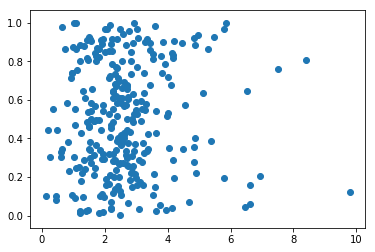

In [15]:
cos_theta = np.abs(pair_d)/pair_3d
plt.scatter(pair_3d, cos_theta)

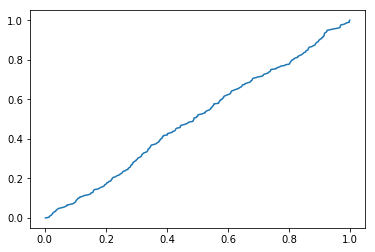

In [91]:
cumulative = np.linspace(0.0,1.0, len(cos_theta))
cos_theta_cum = np.sort(cos_theta)

plt.plot(cos_theta_cum, cumulative)

median delta_d_radial 0.02537703681852932 sigma 1.352255758319047


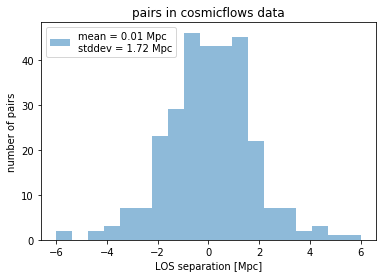

In [92]:
p = np.percentile(pair_d, q=[34,50,66])
print('median delta_d_radial {} sigma {}'.format(p[1], p[2]-p[0]))
a = plt.hist((pair_d), bins=np.linspace(-6,6,20), alpha=0.5, label='mean = {:.2f} Mpc \nstddev = {:.2f} Mpc'.format(pair_d.mean(), pair_d.std()))
plt.xlabel('LOS separation [Mpc]')
plt.ylabel('number of pairs')
plt.title('pairs in cosmicflows data')
plt.legend()

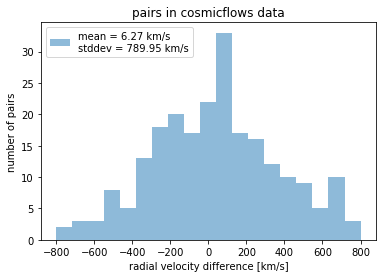

In [93]:
x = pair_v
p = np.percentile(x, q=[34,50,66])
a = plt.hist(x, bins=np.linspace(-800,800,20), alpha=0.5, 
             label='mean = {:.2f} km/s \nstddev = {:.2f} km/s'.format(x.mean(), x.std()))
plt.xlabel('radial velocity difference [km/s]')
plt.ylabel('number of pairs')
plt.title('pairs in cosmicflows data')
plt.legend()